In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import tensorflow as tf
import shutil
import os
os.getcwd()
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from PIL import Image, ImageOps, ImageFilter

%matplotlib inline

In [3]:
## read the data
data = pd.read_csv('jpg_FullIJCNN2013/gt.txt', sep=";", header=None)
data.columns = ["img", "x1", "y1", "x2", "y2", "id"]

print data.shape
tmp = data.copy()

print "Data has image files with traffic signs numbers:", len(data['img'].unique())
print "Data has traffic signs class numbers:", len(data['id'].unique())
print "Data has traffic signs instance numbers:", data['id'].count()

# print(pd.value_counts(data['id'], sort=True))
# data['id'].hist(bins=86)

(1213, 6)
Data has image files with traffic signs numbers: 741
Data has traffic signs class numbers: 43
Data has traffic signs instance numbers: 1213


In [ ]:
for i in range(data.shape[0]):
    data['img'][i] = data['img'].iloc[i].replace('ppm','jpg')


/Users/arindam93/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [3]:
print data.head()

         img   x1   y1    x2   y2  id
0  00000.ppm  774  411   815  446  11
1  00001.ppm  983  388  1024  432  40
2  00001.ppm  386  494   442  552  38
3  00001.ppm  973  335  1031  390  13
4  00002.ppm  892  476  1006  592  39


In [325]:
## Uncomment this cell if you don't have the directory containing the images in JPEG format


# train_img_dir = 'FullIJCNN2013'
# png_img_dir = 'jpg_FullIJCNN2013'


# if os.path.exists(png_img_dir):
#     shutil.rmtree(png_img_dir)
# os.makedirs(png_img_dir) 

# for img_name in os.listdir(train_img_dir):
# #for img_name in ["00000.ppm","00001.ppm","00002.ppm"]:
#     if img_name[-3:] == "ppm":
#         img_path = os.path.join(train_img_dir, img_name)
#         img = Image.open(img_path)
#         png_path = os.path.join(png_img_dir, img_name[:-3]+'jpg')
#         print(png_path)
#         img.save(png_path)
#         #img.show()

0    656
1    557
Name: id, dtype: int64


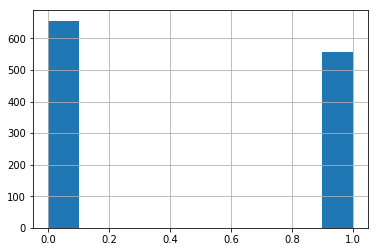

In [4]:

red_round_labels = [0,1,2,3,4,5,7,8,9,10,15,16]   ## prohibitory classes

data['id'] = np.where(tmp['id'].isin(red_round_labels), 1, 0)
print data['id'].value_counts()
data['id'].hist()

labels = data['id'].values
full_data = data.drop('id',1)


In [78]:

x_train, x_test, y_train, y_test = train_test_split(full_data, labels, test_size=0.2, random_state=42)
scaler = preprocessing.MinMaxScaler()

train_data = []
test_data = []

data_dir = 'jpg_FullIJCNN2013'

for i in range(x_train.shape[0]): 
    curr_im = os.path.join(data_dir, x_train['img'].iloc[i])
    img = Image.open(curr_im)
    cropped_rect = (x_train['x1'].iloc[i], x_train['y1'].iloc[i], x_train['x2'].iloc[i], x_train['y2'].iloc[i])
    crop_im = img.crop(cropped_rect)
    ## resize here to 48 x 48
    crop_im = crop_im.resize((48, 48), Image.ANTIALIAS)
    crop_im = ImageOps.autocontrast(crop_im)
    train_data.append(np.array(crop_im))
    

for i in range(x_test.shape[0]): 
    curr_im = os.path.join(data_dir, x_test['img'].iloc[i])
    img = Image.open(curr_im)
    cropped_rect = (x_test['x1'].iloc[i], x_test['y1'].iloc[i], x_test['x2'].iloc[i], x_test['y2'].iloc[i])
    crop_im = img.crop(cropped_rect)
    ## resize here to 48 x 48
    crop_im = crop_im.resize((48, 48), Image.ANTIALIAS)
    crop_im = ImageOps.autocontrast(crop_im)
    test_data.append(np.array(crop_im))
    
train_data = np.array(train_data)
test_data = np.array(test_data)


In [79]:
print train_data.shape
print test_data.shape

(970, 48, 48, 3)
(243, 48, 48, 3)


In [86]:
## one hot encoding of labels
num_train = train_data.shape[0]  ## 970
num_test = test_data.shape[0]    ## 243
num_classes = 2

train_label = np.zeros((num_train, num_classes), dtype=np.int8)   ## 970 x 2 
test_label = np.zeros((num_test, num_classes), dtype=np.int8)     ## 243 x 2

for i in range(num_train):
    if y_train[i] == 1:   ## if the gt is red round sign
        train_label[i][1] = 1
    else:
        train_label[i][0] = 1
        
for i in range(num_test):
    if y_test[i] == 1:
        test_label[i][1] = 1
    else:
        test_label[i][0] = 1
        
print train_label.shape
print test_label.shape
        

(970, 2)
(243, 2)


In [87]:
count = 0
for i in range(len(y_train)):
    if y_train[i] == 1:
        count += 1

print "Number of red round signs in training data: ", count
print "Number of negatives in training data: ", num_train - count

Number of red round signs in training data:  454
Number of negatives in training data:  516


In [88]:
## saving the training and testing data
np.save('train_data.npy', train_data)
np.save('test_data.npy', test_data)
np.save('train_labels.npy', train_label)
np.save('test_labels.npy', test_label)

## Instantiate, Train and Test the CNN model

In [5]:
## load the saved data
train_data = np.load('train_data.npy')
train_labels = np.load('train_labels.npy')
test_data = np.load('test_data.npy')
test_labels = np.load('test_labels.npy')


In [6]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

print train_data.shape
print val_data.shape

(776, 48, 48, 3)
(194, 48, 48, 3)


In [7]:
## batch loader
epochs_completed = 0
idx_epoch = 0
num_train = train_data.shape[0]  ## 776

def get_next_batch(train_data, train_labels, batch_size=8):
    
    global idx_epoch
    global epochs_completed
    
    start = idx_epoch
    idx_epoch = idx_epoch + batch_size
    
    if idx_epoch > num_train:
        epochs_completed += 1
        print "Epochs completed: ", epochs_completed
        print
        perm = np.arange(num_train)
        np.random.shuffle(perm)
        train_images = train_data[perm]
        train_labels = train_labels[perm]
        
        start = 0
        idx_epoch = batch_size
        assert batch_size <= num_train
    
    end = idx_epoch
    return train_data[start:end], train_labels[start:end]
    

In [466]:
## training parameters
learning_rate = 0.0001
num_steps = 1500
batch_size = 12
display_step = 10

## network params
input_height = 48
input_width = 48
num_channels = 3
dropout = 0.5

## create wrappers
def weight_init(shape):
    
    initializer = tf.contrib.layers.xavier_initializer()
    return initializer(shape)
#     return tf.random_normal(shape)

def conv2d(x, W, b, strides=1):
    p = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    p = tf.nn.bias_add(p, b)
    return tf.nn.relu(p)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1,k,k,1], strides=[1,k,k,1], padding='SAME')


weights = {
    'wc1': tf.Variable(weight_init([3, 3, 3, 16])),
    'wc2': tf.Variable(weight_init([3, 3, 16, 32])),
    'wd1': tf.Variable(weight_init([12 * 12 * 32, 256])),
    'out': tf.Variable(weight_init([256, num_classes]))
}

biases = {
    'bc1': tf.Variable(weight_init([16])),
    'bc2': tf.Variable(weight_init([32])),
    'bd1': tf.Variable(weight_init([256])),
    'out': tf.Variable(weight_init([num_classes]))
}


## placeholders
x = tf.placeholder(tf.float32, shape=[None, input_height, input_width, num_channels])
y = tf.placeholder(tf.float32, shape=[None, num_classes])
keep_prob = tf.placeholder(tf.float32)

In [467]:
## define the network

def conv_net(x, weights, biases, dropout):
    
    # Tensor input is 4-D: [Batch Size, Height, Width, Channel]
    
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    batch_m1, batch_var1 = tf.nn.moments(conv1,[0])
    conv1 = tf.nn.batch_normalization(conv1, batch_m1, batch_var1, variance_epsilon=1e-3, offset=None, scale=None)
    conv1 = maxpool2d(conv1)
    
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    batch_m2, batch_var2 = tf.nn.moments(conv2,[0])
    conv2 = tf.nn.batch_normalization(conv2, batch_m2, batch_var2, variance_epsilon=1e-3, offset=None, scale=None)
    conv2 = maxpool2d(conv2)
    
    ## fully connected layer
    ## reshape output of conv2 to fit FC layer
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    
    ## apply dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

In [468]:
logits = conv_net(x, weights, biases, keep_prob)
predictions = tf.nn.softmax(logits)

loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=y))
optim = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss_op)

correct_pred = tf.equal(tf.argmax(predictions, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()

In [469]:
from imgaug import augmenters as iaa
import imgaug as ia

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.Flipud(0.2),
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
    
])

In [470]:
train_loss = []
val_loss = []
train_accuracy = []
val_accuracy = []

patience_cnt = 0
tol = 10


with tf.Session() as sess:
    
    sess.run(init)
    saver = tf.train.Saver()
    
    for step in xrange(1, num_steps+1):
        
        batch_x, batch_y = get_next_batch(train_data, train_labels, batch_size=batch_size)
        batch_x = seq.augment_images(batch_x)
        
        sess.run(optim, feed_dict={x:batch_x, y:batch_y, keep_prob:dropout})
        
        if step % display_step == 0 or step == 1:
            
            loss_train, acc_train = sess.run([loss_op, accuracy], feed_dict={x: train_data, y: train_labels, keep_prob: 1.0})
            loss_val, acc_val = sess.run([loss_op, accuracy], feed_dict={x: val_data, y: val_labels, keep_prob: 1.0})
            
            
            print("Step " + str(step) + ", Train Loss= " + \
                  "{:.4f}".format(loss_train) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc_train) + ", Validation Loss= " + \
                 "{:.4f}".format(loss_val) + ", Validation Accuracy= " + \
                 "{:.3f}".format(acc_val))
            
            train_loss.append(loss_train)
            val_loss.append(loss_val)
            train_accuracy.append(acc_train)
            val_accuracy.append(acc_val)
            
        if step % display_step == 0:
            
            tmp = val_loss[-1] - val_loss[-2]
            if tmp > 0:
                patience_cnt +=1
            else:
                if patience_cnt > 0:
                    patience_cnt -= 1

            
            if patience_cnt > tol:
                print "Early stopping since validation loss is not decreasing"
                break             
    
    print ("optimization done!")
    
    acc_test = sess.run(accuracy, feed_dict={x: test_data, y: test_labels, keep_prob: 1.0})
    print
    print "Testing accuracy: ", acc_test
    
    saver.save(sess, "./my_CNN_model")
               

Step 1, Train Loss= 1.3675, Training Accuracy= 0.535, Validation Loss= 1.0707, Validation Accuracy= 0.562
Step 10, Train Loss= 1.2074, Training Accuracy= 0.571, Validation Loss= 0.9535, Validation Accuracy= 0.613
Step 20, Train Loss= 1.1093, Training Accuracy= 0.591, Validation Loss= 0.8583, Validation Accuracy= 0.644
Step 30, Train Loss= 1.0319, Training Accuracy= 0.608, Validation Loss= 0.7781, Validation Accuracy= 0.670
Step 40, Train Loss= 0.9881, Training Accuracy= 0.616, Validation Loss= 0.7162, Validation Accuracy= 0.727
Step 50, Train Loss= 0.9198, Training Accuracy= 0.640, Validation Loss= 0.6786, Validation Accuracy= 0.706
Step 60, Train Loss= 0.8745, Training Accuracy= 0.647, Validation Loss= 0.6127, Validation Accuracy= 0.732
Epochs completed:  1

Step 70, Train Loss= 0.8407, Training Accuracy= 0.661, Validation Loss= 0.5903, Validation Accuracy= 0.747
Step 80, Train Loss= 0.7996, Training Accuracy= 0.673, Validation Loss= 0.5466, Validation Accuracy= 0.763
Step 90, Train L

Step 740, Train Loss= 0.2244, Training Accuracy= 0.902, Validation Loss= 0.1557, Validation Accuracy= 0.948
Step 750, Train Loss= 0.2245, Training Accuracy= 0.905, Validation Loss= 0.1580, Validation Accuracy= 0.948
Step 760, Train Loss= 0.2298, Training Accuracy= 0.911, Validation Loss= 0.1534, Validation Accuracy= 0.923
Epochs completed:  12

Step 770, Train Loss= 0.2279, Training Accuracy= 0.911, Validation Loss= 0.1506, Validation Accuracy= 0.928
Step 780, Train Loss= 0.2237, Training Accuracy= 0.915, Validation Loss= 0.1471, Validation Accuracy= 0.943
Step 790, Train Loss= 0.2196, Training Accuracy= 0.915, Validation Loss= 0.1444, Validation Accuracy= 0.938
Step 800, Train Loss= 0.2204, Training Accuracy= 0.910, Validation Loss= 0.1418, Validation Accuracy= 0.943
Step 810, Train Loss= 0.2194, Training Accuracy= 0.911, Validation Loss= 0.1318, Validation Accuracy= 0.954
Step 820, Train Loss= 0.2137, Training Accuracy= 0.915, Validation Loss= 0.1320, Validation Accuracy= 0.959
Step 

Step 1480, Train Loss= 0.1216, Training Accuracy= 0.955, Validation Loss= 0.0717, Validation Accuracy= 0.985
Step 1490, Train Loss= 0.1200, Training Accuracy= 0.951, Validation Loss= 0.0694, Validation Accuracy= 0.985
Step 1500, Train Loss= 0.1187, Training Accuracy= 0.951, Validation Loss= 0.0693, Validation Accuracy= 0.985
optimization done!

Testing accuracy:  0.958848


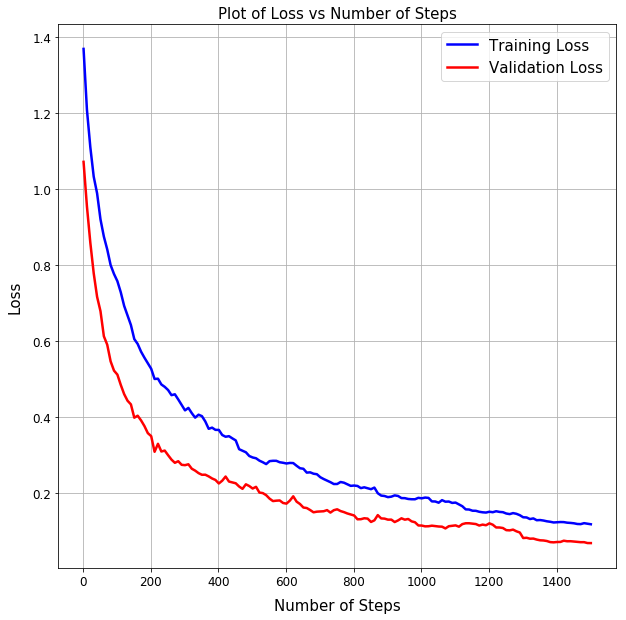

In [471]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

tmp = np.arange(1,1502,10)

plt.xlabel("Number of Steps", size=15)
plt.ylabel("Loss", size=15)
plt.title("Plot of Loss vs Number of Steps", size=15)

ax.plot(tmp, train_loss, 'b', label="Training Loss", linewidth=2.5)
ax.plot(tmp, val_loss, 'r', label="Validation Loss", linewidth=2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
plt.legend(loc='best',prop={'size':15})
plt.grid(True)
plt.show()

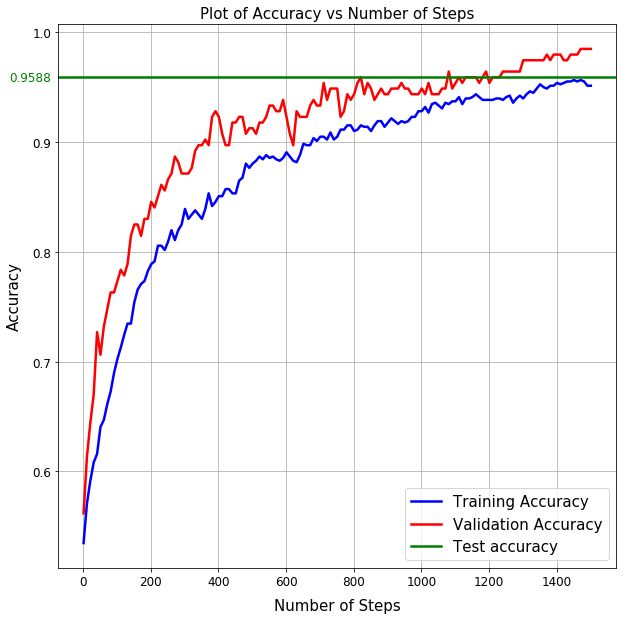

In [482]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

tmp = np.arange(1,1502,10)

plt.xlabel("Number of Steps", size=15)
plt.ylabel("Accuracy", size=15)
plt.title("Plot of Accuracy vs Number of Steps", size=15)

ax.plot(tmp, train_accuracy, 'b', label="Training Accuracy", linewidth=2.5)
ax.plot(tmp, val_accuracy, 'r', label="Validation Accuracy", linewidth=2.5)
ax.axhline(y=acc_test, color='g', linewidth=2.5, label='Test accuracy')

trans = transforms.blended_transform_factory(
    ax.get_yticklabels()[0].get_transform(), ax.transData)
ax.text(0, acc_test, "{:.4f}".format(acc_test), color="g", transform=trans, 
        ha="right", va="center", size=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.xaxis.labelpad=10
ax.yaxis.labelpad=10
plt.legend(loc='best',prop={'size':15})
plt.grid(True)
plt.show()